# TASK 1
extracting claims from three patents related to mobile communictions using `BeautifulSoup`

MIGHT NEED TO INSTALL

In [82]:
# %pip install transformers
# %pip install Flask
# %pip install sentence-transformers
# %pip install scikit-learn
# %pip install requests
# %pip install spacy
# %pip install beautifulsoup4
# %pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [83]:
#from spacy.cli import download

#download("en_core_web_sm")

In [84]:
import requests
from bs4 import BeautifulSoup

In [85]:
# Adding the headline 'Claims' in order to modify the function

def extract_claims_text_from_url(url, headline_text):
    # Creating BeautifulSoup instance
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return None

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the headline with the specified text
    headline = soup.find(lambda tag: tag.name in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6'] and headline_text.lower() in tag.get_text().lower())

    if headline:
        # Get all the following siblings until the next headline or end of section
        content = []
        for sibling in headline.find_next_siblings():
            if sibling.name in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
                break
            content.append(sibling.get_text())


        # Join the content into a single string
        claims_text = "\n".join(content)
        
        # Split the text into individual claims
        claims = [claim.strip() for claim in claims_text.split('\n\n') if claim.strip()]
        return claims
    else:
        return "Headline not found."

### Extracting the claims from the URL and modifing it

In [86]:
headline_text="claims"
claims_text = extract_claims_text_from_url("https://patents.google.com/patent/GB2478972A/en?q=(phone)&oq=phone",headline_text)
claims_text += extract_claims_text_from_url("https://patents.google.com/patent/US9634864B2/en?oq=US9634864B2",headline_text)
claims_text += extract_claims_text_from_url("https://patents.google.com/patent/US9980046B2/en?oq=US9980046B2",headline_text)

# Remove prefix until the first "."

for i in range(len(claims_text)):
    claim = claims_text[i]
    dot_index = claim.find('.')
    if dot_index != -1:
        claims_text[i] = claim[dot_index + 1:].strip()

# TASK 2
#### Grouping claims by topic

### 1. Clusting algorithem
Taken from my late NLP course and my final project, suggesting a clustring algorithem:
1. encode a set of m unhandled requests: R=(r1, r2, r3, …) into their vector representations 
(embeddings) E=(e1, e2, e3, …) using an LLM encoder using `all-MiniLM-L6-v2` and `SentenceTransformer`

2. iterate over representations in E, where each request can be assigned to an existing cluster 
(if its proximity to the cluster’s centroid meets some similarity threshold), otherwise the 
request initiates its own cluster

3. additional iterations over all request embeddings are performed till the algo convergence or 
till the max number of iterations is exhausted

4. clusters with size exceeding a pre-defined min_size are reported as generated clusters

5. all other requests are considered unclustered

full documentation on the encoder - https://huggingface.co/sentence-transformers


In [87]:
import json
from sentence_transformers import SentenceTransformer
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import spacy

MODEL_NAME = 'all-MiniLM-L6-v2'
nlp = spacy.load("en_core_web_sm")


first initialize, means that all the claims vectors are centroids, after one epoch we will update the centroid and keep adjusting

*centroid - will be the mean of all points assigned to that cluster

In [88]:

model = SentenceTransformer(MODEL_NAME)
embeddings = model.encode(claims_text)

clustered = [False] * len(claims_text) # A boolean array that represent if a claim text is tagged or not.

centroids = {} # a dictionary that it's key will be an indexed cluster and it's value will be a list of claims vectors that belongs to that cluster

centroids_sentences = {} #a dictionary that it's key will be an indexed cluster and it's value will be a list of claim texts that belongs to that cluster

cluster = -1


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Than we define our similarity function and threshold

In [89]:
def cosine_similarity(vec1,vec2):
    return round(1.0-cosine(vec1, vec2),3)

In [90]:
def belong_to_centroid(vector, centroid, threshold=0.634):
    similarity = cosine_similarity(vector, centroid)
    return np.all(similarity >= threshold)

now we are foing to iterate over representations in the embeddings, where each claim can be assigned to an existing cluster 
(if its proximity to the cluster’s centroid meets some similarity threshold), otherwise the 
claim initiates its own cluster

In [91]:

for claim in range(len(claims_text)):
    #check if the claim allready clustered, else creates it's new cluster
    if clustered[claim]:
        continue
    cluster += 1
    clustered[claim] = True
    centroids[cluster] = [embeddings[claim]]
    centroids_sentences[cluster] = [claims_text[claim]]
    for emb in range(claim + 1, len(claims_text)):
        if not clustered[emb]:  # meaning embeddings[emb] not belong to any cluster yet
            if belong_to_centroid(embeddings[emb], embeddings[claim]):
                centroids[cluster].append(embeddings[emb])
                centroids_sentences[cluster].append(claims_text[emb])
                clustered[emb] = True

creating a `retrain` loop that will update the centroids 

In [92]:
def retrain(centroids, embeddings, sentences):

    similarity_threshold = 0.634
    updated_centroids = []
    for vectors in centroids.values():
        if len(vectors) != 0:
            updated_centroids.append(np.mean(vectors, axis=0))
        else:
            print("empty")

    clustered = [False] * len(embeddings)
    new_centroids = {}
    new_centroids_sentences = {}
    cluster = -1
    for vec in range(len(embeddings)):
        if clustered[vec]:
            continue
        cluster += 1
        max_similarity = similarity_threshold
        max_similarity_idx = -1
        for centroid in range(len(updated_centroids)):
            if belong_to_centroid(embeddings[vec], updated_centroids[centroid], max_similarity):
                max_similarity = cosine_similarity(embeddings[vec], updated_centroids[centroid])
                max_similarity_idx = centroid

        if max_similarity_idx not in new_centroids:
            new_centroids[max_similarity_idx] = []
            new_centroids_sentences[max_similarity_idx] = []

        new_centroids[max_similarity_idx].append(embeddings[vec])
        new_centroids_sentences[max_similarity_idx].append(sentences[vec])
        clustered[vec] = True

    return new_centroids, new_centroids_sentences


In [93]:
for epoch in range(100):
    centroids, centroids_sentences = retrain(centroids, embeddings, claims_text)

In [94]:
def preprocess(sentences):
    # Lemmatize the sentences using spaCy and exclude stopwords
    lemmatized_sentences = []
    for sentence in sentences:
        doc = nlp(sentence)
        lemmatized_tokens = [token.text for token in doc if (len(doc) <= 4 or not token.is_stop)]
        lemmatized_sentence = " ".join(lemmatized_tokens)
        lemmatized_sentences.append(lemmatized_sentence)
    return lemmatized_sentences

In [95]:
def extract_best_label(sentences):

    preprocessed_sentences = preprocess(sentences)

    # Compute TF-IDF scores for n-gram token sequences (for N in (1,2, 3, 4))
    vectorizer = TfidfVectorizer(ngram_range=(1, 4))
    X = vectorizer.fit_transform(preprocessed_sentences)

    # Get feature names (n-grams)
    feature_names = vectorizer.get_feature_names_out()

    # Compute TF-IDF scores for each n-gram across all documents
    tfidf_scores = np.asarray(X.sum(axis=0)).ravel()

    ngram_lengths = np.array([len(ngram.split())**2 for ngram in feature_names])

    # Adjust TF-IDF scores based on n-gram length
    adjusted_tfidf_scores = tfidf_scores * ngram_lengths

    # Get the index of the n-gram with the highest adjusted TF-IDF score
    best_ngram_idx = np.argmax(adjusted_tfidf_scores)

    # Extract the best fitting cluster name
    best_cluster_name = feature_names[best_ngram_idx]

    return best_cluster_name

In [96]:
def find_best_labels(groups):
    result = {"cluster_list": []}

    for group in groups.values():
        represent = extract_best_label(group)
        result["cluster_list"].append({"cluster_name": represent.lower().strip() + f"[{len(group)}]", "requests": group})


    return result

Dumping the result to a Json file to see the output better

In [97]:
result = find_best_labels(centroids_sentences)
with open('method1.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)

#### Method 1 sum up

The algorithem above may not be the best algorithem you are going to see here in this notebook, but I made it during my finals at the NLP course , I thing it shows knowledge and understanding.

it is a modification of the K - means combined with Hierarchical Clustering in order to answer the unknown number of clusters.

##### Advenages: 


1. Can provide more interpretable results in the form of a nested structure of clusters.

2. It does not require the number of clusters to be specified in advance.


##### Disadventages:

1. More accurate when we can have an estimate number of clusters.

2. Another disadventage that the order matters.

3. Needs tuning(needs to retrain in order to get better results)

##### Results:

In [98]:
number_of_groups=len(result["cluster_list"])
print(f"number of groups: {number_of_groups}")


number of groups: 19


### Method 2: Cluster Paragraph Embeddings using DBSCAN
DBSCAN defines clusters as dense regions of points separated by regions of lower density. It groups together points that are close to each other based on a distance measure

In [99]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2).fit(embeddings)

# Get cluster labels
labels_dbscan = dbscan.labels_
# Group paragraphs by label
clusters_dbscan = {}
for paragraph, label in zip(claims_text, labels_dbscan):
    if label not in clusters_dbscan:
        clusters_dbscan[label] = []
    clusters_dbscan[label].append(paragraph)

result=find_best_labels(clusters_dbscan)
with open('method2.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)




#### Method 2 sum up


##### Adventages:
1. Can find arbitrarily shaped clusters.

2. Can handle with outliers due to its definition of noise points.

3. Does not require specifying the number of clusters beforehand

##### Disadventages:

1. Sensitive to the choice of `eps` and `min_samples` parameters.

2. Struggles with datasets of varying densities and high-dimensional data.

3. May not perform well with clusters of varying densities and sizes.

#### Results:

In [100]:
number_of_groups=len(result["cluster_list"])
print(f"number of groups: {number_of_groups}")

number of groups: 7


### Method 3: K - mean using silhouette

we will use silhoutte score in order to determin the optimal K to use.

In [101]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Function to find the optimal number of clusters
def find_optimal_clusters(embeddings, max_k):
    iters = range(2, max_k+1)
    
    s_scores = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
        s_scores.append(silhouette_score(embeddings, kmeans.labels_))
    
    return iters, s_scores

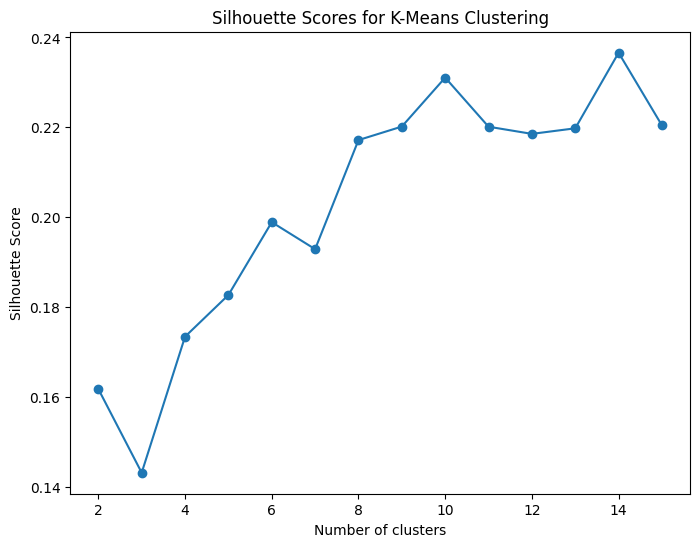

Optimal number of clusters: 14


In [102]:
# Visualize, Visualize , Visualize!!!!!
# Determine the optimal number of clusters
max_k = 15
iters, s_scores = find_optimal_clusters(embeddings, max_k)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(iters, s_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means Clustering')
plt.show()

# Find the optimal number of clusters
optimal_k = iters[s_scores.index(max(s_scores))]
print(f"Optimal number of clusters: {optimal_k}")

In [103]:
# KMean on the optimal number of clusters
def optimal_k_mean(optimal_k):

# Fit KMeans with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(embeddings)

# Get cluster labels
    labels_kmeans = kmeans.labels_

# Group paragraphs by cluster
    clusters_kmeans = {}
    for paragraph, label in zip(claims_text, labels_kmeans):
        if label not in clusters_kmeans:
            clusters_kmeans[label] = []
        clusters_kmeans[label].append(paragraph)
    return clusters_kmeans


In [104]:
# giving meaningful names to clusters and dumping the result to Json.
clusters_kmeans = optimal_k_mean(optimal_k)
result=find_best_labels(clusters_kmeans)
with open('method3.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)

#### Method 3 Sum Up

##### Adventages:

1. Silhouette score provides a quantitative measure of how well each data point fits into its assigned cluster. This helps in assessing the quality of clustering objectively.

2.  K-Means can handle high-dimensional data efficiently, which is beneficial when dealing with complex datasets.

##### Disadvenatges:

1. Computing silhouette scores requires calculating distances between each data point and all other points in its cluster, making it computationally expensive for large datasets or high-dimensional data.

2. Silhouette scores may not perform well with clusters that are not well-separated or have irregular shapes. They assume convex and well-separated clusters.

#### Results:

In [105]:
number_of_groups=len(result["cluster_list"])
print(f"number of groups: {number_of_groups}")

number of groups: 14


# TASK 3
###  Creating an interactive application

I choose the 3rd method over all the above because of the adventages of K mean, when the number of clusters is known or estimated it is a better use.
and the data is small so it should not take a lot of time to do the computations.

In [106]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/group', methods=['GET'])
def group():
        
    num_clusters = int(request.args.get('groups'))
    clusters_kmeans = optimal_k_mean(num_clusters)
    response = {
        'groups': []
    }
    for group in clusters_kmeans.values():
        represent = extract_best_label(group)
        response["groups"].append({"number_of_claims":  f"{len(group)}" , "title": represent.lower().strip()})
    return jsonify(response)


activate the app by deleting the `#` and run it

In [107]:
# def main():
#     app.run(debug=False)


# if __name__ == '__main__':
#     main()
